# Section 1: Statistical Analysis


Adham Mohmed elsaid elwakel
222 100 195


In [24]:
# =============================================================================
# LIBRARY IMPORTS AND CONFIGURATION
# =============================================================================
# This section imports all required libraries and sets up the environment
# for data analysis and visualization.

# Data manipulation libraries
import pandas as pd       # For DataFrames and data manipulation
import numpy as np        # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt   # For creating plots
import seaborn as sns             # For statistical visualizations

# Standard library imports
from collections import defaultdict   # For default dictionaries
import os                             # For file path operations
import sys                            # For system-level operations
import warnings                       # For suppressing warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add parent directory to path for utils import (relative path)
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

# Configure pandas display options
pd.set_option('display.max_columns', None)           # Show all columns
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # 2 decimal places

# Configure matplotlib plot style
plt.style.use('seaborn-v0_8-whitegrid')   # Clean grid background
sns.set_palette('husl')                     # Colorful palette

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Dataset Loading and Validation

Load the Digital Music dataset and verify it meets the requirements:
- ≥ 100,000 users
- ≥ 1,000 products
- ≥ 1 million ratings


In [25]:



DATASET_PATH = '../dataset'    
RESULTS_PATH = '../results'    


os.makedirs(RESULTS_PATH, exist_ok=True)

# Load Digital Music dataset

print("Loading Digital Music dataset...")


ratings = pd.read_csv(
    os.path.join(DATASET_PATH, 'Digital_Music.csv'),  # Construct full path
    header=None,                                       # No header in CSV
    names=['item_id', 'user_id', 'rating', 'timestamp']  # Column names
)

# Display dataset information
print(f"\nRatings shape: {ratings.shape}")
print(f"Memory usage: {ratings.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Loading Digital Music dataset...

Ratings shape: (1584082, 4)
Memory usage: 208.08 MB


In [26]:
print("--- Ratings Sample ---")
display(ratings.head(10))

print("\n--- Ratings Info ---")
print(ratings.info())


--- Ratings Sample ---


,item_id,user_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.00,1387670400
1,0001388703,AC2PL52NKPL29,5.00,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.00,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.00,1354406400
4,0001388703,A12R54MKO17TW0,5.00,1325894400
5,0001388703,A25ZT87OMIPLNX,5.00,1247011200
6,0001388703,A3NVGWKHLULDHR,1.00,1242259200
7,0001388703,AT7OB43GHKIUA,5.00,1209859200
8,0001388703,A1H3X1TW6Y7HD8,5.00,1442534400
9,0001388703,AZ3T21W6CW0MW,1.00,1431648000



--- Ratings Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   item_id    1584082 non-null  object 
 1   user_id    1584082 non-null  object 
 2   rating     1584082 non-null  float64
 3   timestamp  1584082 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 48.3+ MB
None


In [27]:

unique_users = set()
for user in ratings['user_id']:
    unique_users.add(user)
n_users = len(unique_users)

unique_items = set()
for item in ratings['item_id']:
    unique_items.add(item)
n_items = len(unique_items)

n_ratings = 0
for _ in ratings.itertuples():
    n_ratings += 1

print("=" * 50)
print("DATASET VALIDATION (Manual Calculation)")
print("=" * 50)
print(f"Number of unique users: {n_users:,}")
print(f"Number of unique items (products): {n_items:,}")
print(f"Total number of ratings: {n_ratings:,}")
print("=" * 50)




DATASET VALIDATION (Manual Calculation)
Number of unique users: 840,372
Number of unique items (products): 456,992
Total number of ratings: 1,584,082


## 2. Preprocess Dataset - Adjust Ratings to 1-5 Scale

Verify ratings are on the 1-5 scale. If not, normalize them.


In [28]:
print("Rating Distribution Before Preprocessing (Manual Count):")

rating_count_dict = {}
for rating in ratings['rating']:
    if rating in rating_count_dict:
        rating_count_dict[rating] += 1
    else:
        rating_count_dict[rating] = 1

# Sort and print
for rating in sorted(rating_count_dict.keys()):
    print(f"  {rating}: {rating_count_dict[rating]:,}")

# Find min and max manually 
min_rating_val = None
max_rating_val = None
for rating in ratings['rating']:
    if min_rating_val is None or rating < min_rating_val:
        min_rating_val = rating
    if max_rating_val is None or rating > max_rating_val:
        max_rating_val = rating

print(f"\nMin rating: {min_rating_val}")
print(f"Max rating: {max_rating_val}")


Rating Distribution Before Preprocessing (Manual Count):
  1.0: 43,108
  2.0: 23,551
  3.0: 57,347
  4.0: 179,929
  5.0: 1,280,147

Min rating: 1.0
Max rating: 5.0


In [29]:
# Verify ratings are already on 1-5 scale
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

if min_rating >= 1 and max_rating <= 5:
    print("Ratings are already on 1-5 scale. No preprocessing needed.")
else:
    # Normalize to 1-5 scale 
    print("Normalizing ratings to 1-5 scale...")
    ratings['rating'] = 1 + (ratings['rating'] - min_rating) * 4 / (max_rating - min_rating)
    ratings['rating'] = ratings['rating'].round(2)
    print("Ratings normalized.")

print(f"\nRating range: {ratings['rating'].min()} - {ratings['rating'].max()}")


Ratings are already on 1-5 scale. No preprocessing needed.

Rating range: 1.0 - 5.0


## 3. Calculate Number of Ratings per User (n_u)

Calculate and save the number of ratings for each user.


In [30]:
# Calculate number of ratings per user (n_u) 

# Step 1: Count ratings per user using a dictionary and loop
user_rating_counts = {}
for row in ratings.itertuples():
    user = row.user_id
    if user in user_rating_counts:
        user_rating_counts[user] += 1
    else:
        user_rating_counts[user] = 1

# Convert to DataFrame
n_u = pd.DataFrame(list(user_rating_counts.items()), columns=['user_id', 'nu'])

# Step 2: Calculate statistics 
# Find min
min_nu = None
for val in n_u['nu']:
    if min_nu is None or val < min_nu:
        min_nu = val

# Find max
max_nu = None
for val in n_u['nu']:
    if max_nu is None or val > max_nu:
        max_nu = val

# Calculate mean 
total_sum = 0
count = 0
for val in n_u['nu']:
    total_sum += val
    count += 1
mean_nu = round(total_sum / count, 2)

# Calculate median 
sorted_values = sorted(n_u['nu'].tolist())
n = len(sorted_values)
if n % 2 == 0:
    median_nu = (sorted_values[n//2 - 1] + sorted_values[n//2]) / 2
else:
    median_nu = sorted_values[n//2]

print("Number of Ratings per User (n_u)")
print(f"  Total users: {len(n_u):,}")
print(f"  Min ratings per user: {min_nu}")
print(f"  Max ratings per user: {max_nu}")
print(f"  Mean ratings per user: {mean_nu}")
print(f"  Median ratings per user: {median_nu}")

# Display sample
print("\nSample:")
display(n_u.head(10))

# Save n_u to results
n_u.to_csv(os.path.join(RESULTS_PATH, 'nu_ratings_per_user.csv'), index=False)
print("✓ Saved: nu_ratings_per_user.csv")


Number of Ratings per User (n_u)
  Total users: 840,372
  Min ratings per user: 1
  Max ratings per user: 1326
  Mean ratings per user: 1.88
  Median ratings per user: 1.0

Sample:


,user_id,nu
0,A1ZCPG3D3HGRSS,1
1,AC2PL52NKPL29,1
2,A1SUZXBDZSDQ3A,1
3,A3A0W7FZXM0IZW,1
4,A12R54MKO17TW0,51
5,A25ZT87OMIPLNX,1
6,A3NVGWKHLULDHR,1
7,AT7OB43GHKIUA,1
8,A1H3X1TW6Y7HD8,1
9,AZ3T21W6CW0MW,1


✓ Saved: nu_ratings_per_user.csv


## 4. Calculate Number of Ratings per Item (n_i)

Calculate and save the number of ratings for each item (product).


In [31]:
# Calculate number of ratings per item (n_i) 

# Step 1: Count ratings per item using a dictionary and loop
item_rating_counts = {}
for row in ratings.itertuples():
    item = row.item_id
    if item in item_rating_counts:
        item_rating_counts[item] += 1
    else:
        item_rating_counts[item] = 1

# Convert to DataFrame
n_i = pd.DataFrame(list(item_rating_counts.items()), columns=['item_id', 'ni'])

# Step 2: Calculate statistics
# Find min
min_ni = None
for val in n_i['ni']:
    if min_ni is None or val < min_ni:
        min_ni = val

# Find max
max_ni = None
for val in n_i['ni']:
    if max_ni is None or val > max_ni:
        max_ni = val

# Calculate mean 
total_sum = 0
count = 0
for val in n_i['ni']:
    total_sum += val
    count += 1
mean_ni = round(total_sum / count, 2)

# Calculate median
sorted_values = sorted(n_i['ni'].tolist())
n = len(sorted_values)
if n % 2 == 0:
    median_ni = (sorted_values[n//2 - 1] + sorted_values[n//2]) / 2
else:
    median_ni = sorted_values[n//2]

print("Number of Ratings per Item (n_i) - Manual Calculation:")
print(f"  Total items: {len(n_i):,}")
print(f"  Min ratings per item: {min_ni}")
print(f"  Max ratings per item: {max_ni}")
print(f"  Mean ratings per item: {mean_ni}")
print(f"  Median ratings per item: {median_ni}")

# Display sample
print("\nSample:")
display(n_i.head(10))

# Save n_i to results
n_i.to_csv(os.path.join(RESULTS_PATH, 'ni_ratings_per_item.csv'), index=False)
print("✓ Saved: ni_ratings_per_item.csv")


Number of Ratings per Item (n_i) - Manual Calculation:
  Total items: 456,992
  Min ratings per item: 1
  Max ratings per item: 3411
  Mean ratings per item: 3.47
  Median ratings per item: 1.0

Sample:


,item_id,ni
0,0001388703,28
1,0001526146,46
2,0001527134,33
3,0001377647,39
4,0006935257,41
5,0006920055,38
6,0615897398,12
7,0760131694,17
8,0760103453,17
9,0830838015,15


✓ Saved: ni_ratings_per_item.csv


## 5. Compute Average Ratings per User (r_u)

Calculate and save the average rating given by each user.


In [32]:
# Calculate average ratings per user (r_u) 

# Step 1: Calculate sum and count of ratings per user using loops
user_rating_sum = {}
user_rating_count = {}
for row in ratings.itertuples():
    user = row.user_id
    rating = row.rating
    if user in user_rating_sum:
        user_rating_sum[user] += rating
        user_rating_count[user] += 1
    else:
        user_rating_sum[user] = rating
        user_rating_count[user] = 1

# Step 2: Calculate average manually for each user
user_avg_ratings = {}
for user in user_rating_sum:
    avg = user_rating_sum[user] / user_rating_count[user]
    user_avg_ratings[user] = round(avg, 2)

# Convert to DataFrame
r_u = pd.DataFrame(list(user_avg_ratings.items()), columns=['user_id', 'ru'])

# Step 3: Calculate statistics manually using loops
# Find min
min_ru = None
for val in r_u['ru']:
    if min_ru is None or val < min_ru:
        min_ru = val

# Find max
max_ru = None
for val in r_u['ru']:
    if max_ru is None or val > max_ru:
        max_ru = val

# Calculate mean manually
total_sum = 0
count = 0
for val in r_u['ru']:
    total_sum += val
    count += 1
mean_ru = round(total_sum / count, 2)

# Calculate standard deviation manually
# First calculate variance: sum((x - mean)^2) / n
variance_sum = 0
for val in r_u['ru']:
    variance_sum += (val - mean_ru) ** 2
variance = variance_sum / count
std_ru = round(variance ** 0.5, 2)  # sqrt of variance

print("Average Ratings per User (r_u)")
print(f"  Min avg rating: {min_ru}")
print(f"  Max avg rating: {max_ru}")
print(f"  Mean of avg ratings: {mean_ru}")
print(f"  Std of avg ratings: {std_ru}")

# Display sample
print("\nSample:")
display(r_u.head(10))

# Save r_u to results
r_u.to_csv(os.path.join(RESULTS_PATH, 'ru_avg_ratings_per_user.csv'), index=False)
print("✓ Saved: ru_avg_ratings_per_user.csv")


Average Ratings per User (r_u)
  Min avg rating: 1.0
  Max avg rating: 5.0
  Mean of avg ratings: 4.65
  Std of avg ratings: 0.86

Sample:


,user_id,ru
0,A1ZCPG3D3HGRSS,5.00
1,AC2PL52NKPL29,5.00
2,A1SUZXBDZSDQ3A,5.00
3,A3A0W7FZXM0IZW,5.00
4,A12R54MKO17TW0,4.73
5,A25ZT87OMIPLNX,5.00
6,A3NVGWKHLULDHR,1.00
7,AT7OB43GHKIUA,5.00
8,A1H3X1TW6Y7HD8,5.00
9,AZ3T21W6CW0MW,1.00


✓ Saved: ru_avg_ratings_per_user.csv


## 6. Compute Average Ratings per Item (r_i)

Calculate and save the average rating received by each item (product).


In [33]:
# Calculate average ratings per item (r_i)

# Step 1: Calculate sum and count of ratings per item using loops
item_rating_sum = {}
item_rating_count = {}
for row in ratings.itertuples():
    item = row.item_id
    rating = row.rating
    if item in item_rating_sum:
        item_rating_sum[item] += rating
        item_rating_count[item] += 1
    else:
        item_rating_sum[item] = rating
        item_rating_count[item] = 1

# Step 2: Calculate average manually for each item
item_avg_ratings = {}
for item in item_rating_sum:
    avg = item_rating_sum[item] / item_rating_count[item]
    item_avg_ratings[item] = round(avg, 2)

# Convert to DataFrame
r_i = pd.DataFrame(list(item_avg_ratings.items()), columns=['item_id', 'ri'])

# Step 3: Calculate statistics manually
# Find min
min_ri = None
for val in r_i['ri']:
    if min_ri is None or val < min_ri:
        min_ri = val

# Find max
max_ri = None
for val in r_i['ri']:
    if max_ri is None or val > max_ri:
        max_ri = val

# Calculate mean manually
total_sum = 0
count = 0
for val in r_i['ri']:
    total_sum += val
    count += 1
mean_ri = round(total_sum / count, 2)

# Calculate standard deviation
variance_sum = 0
for val in r_i['ri']:
    variance_sum += (val - mean_ri) ** 2
variance = variance_sum / count
std_ri = round(variance ** 0.5, 2)

print("Average Ratings per Item (r_i)")
print(f"  Min avg rating: {min_ri}")
print(f"  Max avg rating: {max_ri}")
print(f"  Mean of avg ratings: {mean_ri}")
print(f"  Std of avg ratings: {std_ri}")

# Display sample
print("\nSample:")
display(r_i.head(10))

# Save r_i to results
r_i.to_csv(os.path.join(RESULTS_PATH, 'ri_avg_ratings_per_item.csv'), index=False)
print("✓ Saved: ri_avg_ratings_per_item.csv")


Average Ratings per Item (r_i)
  Min avg rating: 1.0
  Max avg rating: 5.0
  Mean of avg ratings: 4.65
  Std of avg ratings: 0.76

Sample:


,item_id,ri
0,0001388703,4.57
1,0001526146,4.89
2,0001527134,4.88
3,0001377647,5.00
4,0006935257,4.85
5,0006920055,4.92
6,0615897398,5.00
7,0760131694,4.76
8,0760103453,4.29
9,0830838015,4.73


✓ Saved: ri_avg_ratings_per_item.csv


## 7. Order and Plot Distribution of Ratings per Item (Ascending)

Sort items by their total number of ratings and visualize the distribution.


In [34]:
# Sort items by number of ratings (ascending)
n_i_sorted = n_i.sort_values('ni', ascending=True).reset_index(drop=True)
n_i_sorted['rank'] = range(1, len(n_i_sorted) + 1)

print("Items sorted by number of ratings (ascending):")
print("\nLeast rated items:")
display(n_i_sorted.head(10))

print("\nMost rated items:")
display(n_i_sorted.tail(10))


Items sorted by number of ratings (ascending):

Least rated items:


,item_id,ni,rank
0,B00721JZX8,1,1
1,B000NY14IK,1,2
2,B004H04F8C,1,3
3,B005HTQ5ZI,1,4
4,B001AJRMKG,1,5
5,B005HTI8A8,1,6
6,B005HTHJBW,1,7
7,B000WIL8UG,1,8
8,B000QMMPAA,1,9
9,B005HTHKL6,1,10



Most rated items:


,item_id,ni,rank
456982,B0099G7KDQ,1424,456983
456983,B0170K9UTO,1463,456984
456984,B00136NUG6,1576,456985
456985,B005MVLI8A,1738,456986
456986,B0092MKTL2,1927,456987
456987,B00U3WJHCW,2046,456988
456988,B00NPZI1ZS,2195,456989
456989,B00CZF8B68,2819,456990
456990,B00M8JCW3E,3243,456991
456991,B0135P6PZA,3411,456992


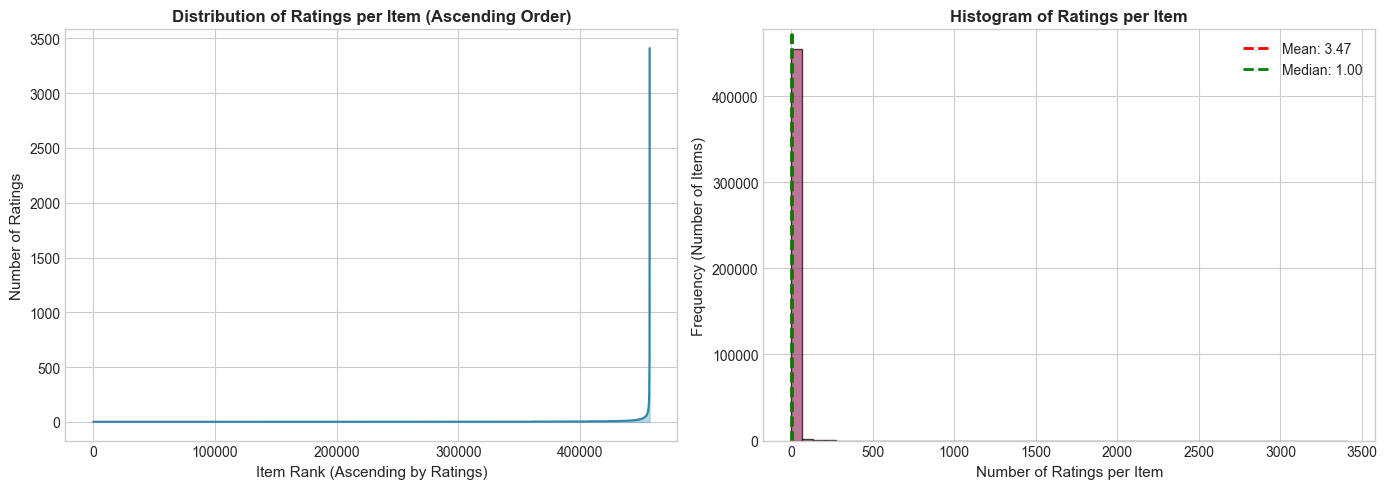

✓ Saved: distribution_ratings_per_item.png


In [35]:
# Plot distribution of ratings per item
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sorted distribution (ascending)
axes[0].plot(n_i_sorted['rank'], n_i_sorted['ni'], linewidth=1.5, color='#2E86AB')
axes[0].set_xlabel('Item Rank (Ascending by Ratings)', fontsize=11)
axes[0].set_ylabel('Number of Ratings', fontsize=11)
axes[0].set_title('Distribution of Ratings per Item (Ascending Order)', fontsize=12, fontweight='bold')
axes[0].fill_between(n_i_sorted['rank'], n_i_sorted['ni'], alpha=0.3, color='#2E86AB')

# Plot 2: Histogram of ratings per item
axes[1].hist(n_i['ni'], bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[1].set_xlabel('Number of Ratings per Item', fontsize=11)
axes[1].set_ylabel('Frequency (Number of Items)', fontsize=11)
axes[1].set_title('Histogram of Ratings per Item', fontsize=12, fontweight='bold')
axes[1].axvline(n_i['ni'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {n_i["ni"].mean():.2f}')
axes[1].axvline(n_i['ni'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {n_i["ni"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'distribution_ratings_per_item.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: distribution_ratings_per_item.png")


## 8. Group Products by Average Ratings (G1-G10)

Classify products into 10 groups based on their average ratings as percentiles:
- G1: ≤ 1%
- G2: 1% < x ≤ 5%
- G3: 5% < x ≤ 10%
- G4: 10% < x ≤ 20%
- G5: 20% < x ≤ 30%
- G6: 30% < x ≤ 40%
- G7: 40% < x ≤ 50%
- G8: 50% < x ≤ 60%
- G9: 60% < x ≤ 70%
- G10: 70% < x ≤ 100%


In [36]:
# Merge n_i with r_i to get both number and average of ratings per item
item_stats = n_i.merge(r_i, on='item_id')

# Calculate percentile rank for each item based on average rating
max_avg_rating = 5.0

def assign_group(avg_rating, max_rating=5.0):
    """
    Assign item to group based on average rating percentage.
    Groups are based on what percentage of max rating the item has.
    """
    percentage = (avg_rating / max_rating) * 100
    
    if percentage <= 1:
        return 'G1'
    elif percentage <= 5:
        return 'G2'
    elif percentage <= 10:
        return 'G3'
    elif percentage <= 20:
        return 'G4'
    elif percentage <= 30:
        return 'G5'
    elif percentage <= 40:
        return 'G6'
    elif percentage <= 50:
        return 'G7'
    elif percentage <= 60:
        return 'G8'
    elif percentage <= 70:
        return 'G9'
    else:
        return 'G10'

# Assign groups
item_stats['group'] = item_stats['ri'].apply(assign_group)

print("Items assigned to groups:")
display(item_stats.head(10))

# Count number of products in each group
group_counts = item_stats['group'].value_counts().sort_index()

print("\nNumber of Products in Each Group:")
print("=" * 40)
for group in ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']:
    count = group_counts.get(group, 0)
    print(f"  {group}: {count:,} products")
print("=" * 40)
print(f"  Total: {group_counts.sum():,} products")


Items assigned to groups:


,item_id,ni,ri,group
0,0001388703,28,4.57,G10
1,0001526146,46,4.89,G10
2,0001527134,33,4.88,G10
3,0001377647,39,5.00,G10
4,0006935257,41,4.85,G10
5,0006920055,38,4.92,G10
6,0615897398,12,5.00,G10
7,0760131694,17,4.76,G10
8,0760103453,17,4.29,G10
9,0830838015,15,4.73,G10



Number of Products in Each Group:
  G1: 0 products
  G2: 0 products
  G3: 0 products
  G4: 8,871 products
  G5: 242 products
  G6: 4,577 products
  G7: 1,032 products
  G8: 14,857 products
  G9: 3,473 products
  G10: 423,940 products
  Total: 456,992 products


In [37]:
# Calculate total ratings in each group
group_ratings = item_stats.groupby('group')['ni'].sum().reset_index(name='total_ratings')

# Ensure all groups are present
all_groups = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']
group_ratings_full = pd.DataFrame({'group': all_groups})
group_ratings_full = group_ratings_full.merge(group_ratings, on='group', how='left').fillna(0)
group_ratings_full['total_ratings'] = group_ratings_full['total_ratings'].astype(int)

print("Total Ratings in Each Group (Original Order):")
display(group_ratings_full)

# Sort by total ratings (ascending)
group_ratings_sorted = group_ratings_full.sort_values('total_ratings', ascending=True).reset_index(drop=True)

print("\nTotal Ratings in Each Group (Ascending Order):")
display(group_ratings_sorted)

# Save group statistics
group_stats = group_ratings_full.copy()
group_stats['num_products'] = group_stats['group'].map(group_counts).fillna(0).astype(int)
group_stats.to_csv(os.path.join(RESULTS_PATH, 'group_statistics.csv'), index=False)
print("✓ Saved: group_statistics.csv")


Total Ratings in Each Group (Original Order):


,group,total_ratings
0,G1,0
1,G2,0
2,G3,0
3,G4,9642
4,G5,1348
5,G6,6029
6,G7,3417
7,G8,22387
8,G9,15504
9,G10,1525755



Total Ratings in Each Group (Ascending Order):


,group,total_ratings
0,G1,0
1,G2,0
2,G3,0
3,G5,1348
4,G7,3417
5,G6,6029
6,G4,9642
7,G9,15504
8,G8,22387
9,G10,1525755


✓ Saved: group_statistics.csv


## 10. Plot Distribution of Ratings by Group (Before and After Ordering)


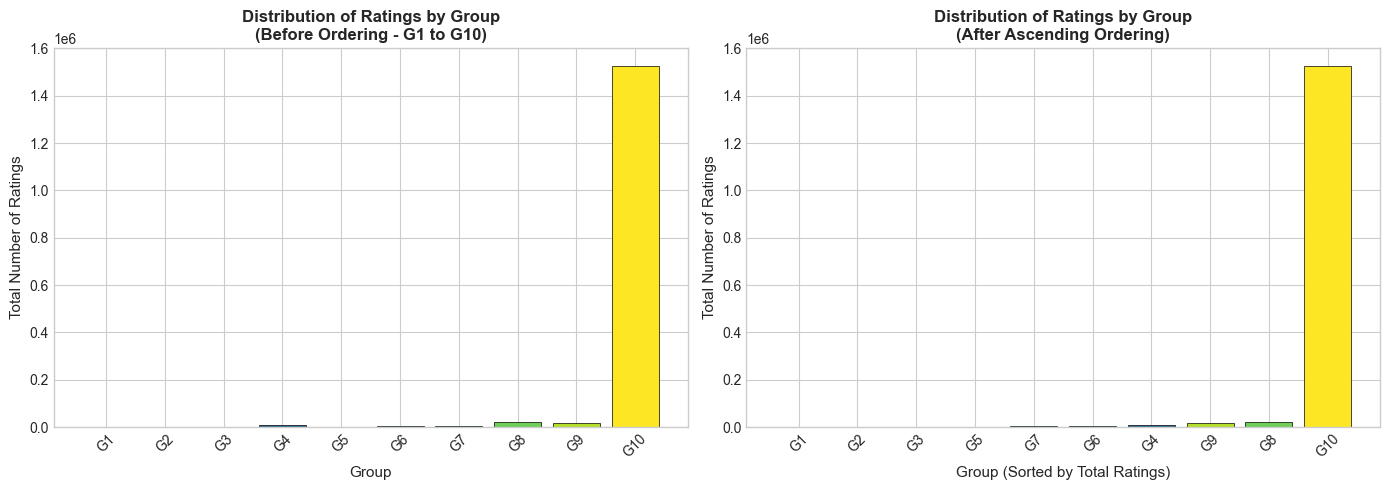

✓ Saved: group_ratings_distribution.png


In [38]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Plot 1: Before ordering (G1-G10 in order)
bars1 = axes[0].bar(group_ratings_full['group'], group_ratings_full['total_ratings'], 
                    color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Group', fontsize=11)
axes[0].set_ylabel('Total Number of Ratings', fontsize=11)
axes[0].set_title('Distribution of Ratings by Group\n(Before Ordering - G1 to G10)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: After ordering (ascending by total ratings)
bars2 = axes[1].bar(range(len(group_ratings_sorted)), group_ratings_sorted['total_ratings'], 
                    color=[colors[all_groups.index(g)] for g in group_ratings_sorted['group']], 
                    edgecolor='black', linewidth=0.5)
axes[1].set_xticks(range(len(group_ratings_sorted)))
axes[1].set_xticklabels(group_ratings_sorted['group'])
axes[1].set_xlabel('Group (Sorted by Total Ratings)', fontsize=11)
axes[1].set_ylabel('Total Number of Ratings', fontsize=11)
axes[1].set_title('Distribution of Ratings by Group\n(After Ascending Ordering)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'group_ratings_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: group_ratings_distribution.png")


## 11. Select Three Target Users

Select target users based on their rating percentile:
- U1: ≤ 2% ratings
- U2: > 2% and ≤ 5% ratings
- U3: ≥ 5% and ≤ 10% ratings


In [39]:
# Calculate rating percentiles for users
max_user_ratings = n_u['nu'].max()
min_user_ratings = n_u['nu'].min()

# Calculate percentile rank (0-100)
n_u['rating_percentile'] = n_u['nu'].rank(pct=True) * 100
n_u['rating_percentile'] = n_u['rating_percentile'].round(2)

print(f"User ratings range: {min_user_ratings} - {max_user_ratings}")
print(f"\nUser rating percentile distribution:")
print(n_u['rating_percentile'].describe())
print(f"\nUsers in bottom 2%: {len(n_u[n_u['rating_percentile'] <= 2])}")
print(f"Users in 2-5%: {len(n_u[(n_u['rating_percentile'] > 2) & (n_u['rating_percentile'] <= 5)])}")
print(f"Users in 5-10%: {len(n_u[(n_u['rating_percentile'] > 5) & (n_u['rating_percentile'] <= 10)])}")


User ratings range: 1 - 1326

User rating percentile distribution:
count   840372.00
mean        50.00
std         22.89
min         35.82
25%         35.82
50%         35.82
75%         79.15
max        100.00
Name: rating_percentile, dtype: float64

Users in bottom 2%: 0
Users in 2-5%: 0
Users in 5-10%: 0


In [40]:
# Select target users
# U1: ≤ 2% ratings (bottom 2% of users)
u1_candidates = n_u[n_u['rating_percentile'] <= 2]
if len(u1_candidates) == 0:
    u1_candidates = n_u.nsmallest(int(len(n_u) * 0.02), 'nu')
U1 = u1_candidates.sample(1, random_state=42).iloc[0]

# U2: > 2% and ≤ 5% ratings
u2_candidates = n_u[(n_u['rating_percentile'] > 2) & (n_u['rating_percentile'] <= 5)]
if len(u2_candidates) == 0:
    lower = n_u['nu'].quantile(0.02)
    upper = n_u['nu'].quantile(0.05)
    u2_candidates = n_u[(n_u['nu'] > lower) & (n_u['nu'] <= upper)]
U2 = u2_candidates.sample(1, random_state=42).iloc[0] if len(u2_candidates) > 0 else None

# U3: > 5% and ≤ 10% ratings
u3_candidates = n_u[(n_u['rating_percentile'] > 5) & (n_u['rating_percentile'] <= 10)]
if len(u3_candidates) == 0:
    lower = n_u['nu'].quantile(0.05)
    upper = n_u['nu'].quantile(0.10)
    u3_candidates = n_u[(n_u['nu'] > lower) & (n_u['nu'] <= upper)]
U3 = u3_candidates.sample(1, random_state=42).iloc[0] if len(u3_candidates) > 0 else None

print("=" * 60)
print("SELECTED TARGET USERS")
print("=" * 60)
print(f"\nU1 (≤ 2% - bottom percentile, fewest ratings):")
print(f"  User ID: {U1['user_id']}")
print(f"  Number of ratings: {int(U1['nu'])}")
print(f"  Percentile rank: {U1['rating_percentile']}%")

if U2 is not None:
    print(f"\nU2 (> 2% and ≤ 5% percentile):")
    print(f"  User ID: {U2['user_id']}")
    print(f"  Number of ratings: {int(U2['nu'])}")
    print(f"  Percentile rank: {U2['rating_percentile']}%")

if U3 is not None:
    print(f"\nU3 (> 5% and ≤ 10% percentile):")
    print(f"  User ID: {U3['user_id']}")
    print(f"  Number of ratings: {int(U3['nu'])}")
    print(f"  Percentile rank: {U3['rating_percentile']}%")
print("=" * 60)

# Save target users
target_users = pd.DataFrame({
    'target': ['U1', 'U2', 'U3'],
    'user_id': [U1['user_id'], U2['user_id'] if U2 is not None else None, 
                U3['user_id'] if U3 is not None else None],
    'num_ratings': [int(U1['nu']), int(U2['nu']) if U2 is not None else None,
                    int(U3['nu']) if U3 is not None else None],
    'rating_percentile': [U1['rating_percentile'], U2['rating_percentile'] if U2 is not None else None,
                          U3['rating_percentile'] if U3 is not None else None]
})
target_users.to_csv(os.path.join(RESULTS_PATH, 'target_users.csv'), index=False)
print("✓ Saved: target_users.csv")
display(target_users)


SELECTED TARGET USERS

U1 (≤ 2% - bottom percentile, fewest ratings):
  User ID: A34K2FO44NYURI
  Number of ratings: 1
  Percentile rank: 35.82%
✓ Saved: target_users.csv


,target,user_id,num_ratings,rating_percentile
0,U1,A34K2FO44NYURI,1.00,35.82
1,U2,None,NaN,NaN
2,U3,None,NaN,NaN


## 12. Select Two Target Items (Lowest Rated)

Select the two lowest rated items (I1 and I2) as target items.


In [41]:
# Select two lowest rated items (by average rating)
lowest_rated = r_i.nsmallest(2, 'ri')

I1 = lowest_rated.iloc[0]
I2 = lowest_rated.iloc[1]

# Get additional info
I1_info = item_stats[item_stats['item_id'] == I1['item_id']].iloc[0]
I2_info = item_stats[item_stats['item_id'] == I2['item_id']].iloc[0]

print("=" * 60)
print("SELECTED TARGET ITEMS (LOWEST RATED)")
print("=" * 60)
print(f"\nI1 (Lowest rated item):")
print(f"  Item ID: {I1['item_id']}")
print(f"  Average rating: {I1['ri']}")
print(f"  Number of ratings: {int(I1_info['ni'])}")

print(f"\nI2 (Second lowest rated item):")
print(f"  Item ID: {I2['item_id']}")
print(f"  Average rating: {I2['ri']}")
print(f"  Number of ratings: {int(I2_info['ni'])}")
print("=" * 60)

# Save target items
target_items = pd.DataFrame({
    'target': ['I1', 'I2'],
    'item_id': [I1['item_id'], I2['item_id']],
    'avg_rating': [I1['ri'], I2['ri']],
    'num_ratings': [int(I1_info['ni']), int(I2_info['ni'])]
})
target_items.to_csv(os.path.join(RESULTS_PATH, 'target_items.csv'), index=False)
print("✓ Saved: target_items.csv")
display(target_items)


SELECTED TARGET ITEMS (LOWEST RATED)

I1 (Lowest rated item):
  Item ID: B00NIJY63W
  Average rating: 1.0
  Number of ratings: 44

I2 (Second lowest rated item):
  Item ID: B00S33PD6W
  Average rating: 1.0
  Number of ratings: 73
✓ Saved: target_items.csv


,target,item_id,avg_rating,num_ratings
0,I1,B00NIJY63W,1.00,44
1,I2,B00S33PD6W,1.00,73


## 13. Co-rating Analysis

Count:
- Number of co-rating users between each target user and other users (No_common_users)
- Number of co-rated items between each target item and other items (No_coRated_items)


In [42]:
# Create user-item sets for efficient computation
print("Building user-item mappings...")
print("This may take a while due to the large dataset size...")

# Get items rated by each user
user_items = ratings.groupby('user_id')['item_id'].apply(set).to_dict()

# Get users who rated each item
item_users = ratings.groupby('item_id')['user_id'].apply(set).to_dict()

print(f"Created mappings for {len(user_items):,} users and {len(item_users):,} items.")


Building user-item mappings...
This may take a while due to the large dataset size...
Created mappings for 840,372 users and 456,992 items.


In [43]:
# Calculate co-rating users for each target user
def count_common_items_with_users(target_user_id, user_items_dict):
    """Count users who have rated at least one common item with target user."""
    target_items = user_items_dict.get(target_user_id, set())
    common_counts = {}
    
    for user_id, items in user_items_dict.items():
        if user_id != target_user_id:
            common = len(target_items & items)
            if common > 0:
                common_counts[user_id] = common
    
    return common_counts

print("Computing co-rating users for target users...")
print("(This may take several minutes for the Electronics dataset)")

# For U1
U1_id = U1['user_id']
U1_common = count_common_items_with_users(U1_id, user_items)
U1_corating_count = len(U1_common)

# For U2
U2_id = U2['user_id'] if U2 is not None else None
if U2_id:
    U2_common = count_common_items_with_users(U2_id, user_items)
    U2_corating_count = len(U2_common)
else:
    U2_corating_count = 0

# For U3
U3_id = U3['user_id'] if U3 is not None else None
if U3_id:
    U3_common = count_common_items_with_users(U3_id, user_items)
    U3_corating_count = len(U3_common)
else:
    U3_corating_count = 0

print("\n" + "=" * 60)
print("CO-RATING USERS ANALYSIS")
print("=" * 60)
print(f"U1 (user_id={U1_id}): {U1_corating_count:,} users have common ratings")
if U2_id:
    print(f"U2 (user_id={U2_id}): {U2_corating_count:,} users have common ratings")
if U3_id:
    print(f"U3 (user_id={U3_id}): {U3_corating_count:,} users have common ratings")
print("=" * 60)


Computing co-rating users for target users...
(This may take several minutes for the Electronics dataset)

CO-RATING USERS ANALYSIS
U1 (user_id=A34K2FO44NYURI): 17 users have common ratings


In [44]:
# Calculate co-rated items for each target item
def count_common_users_with_items(target_item_id, item_users_dict):
    """Count items that share at least one common rater with target item."""
    target_users = item_users_dict.get(target_item_id, set())
    common_counts = {}
    
    for item_id, users in item_users_dict.items():
        if item_id != target_item_id:
            common = len(target_users & users)
            if common > 0:
                common_counts[item_id] = common
    
    return common_counts

print("Computing co-rated items for target items...")

# For I1
I1_id = I1['item_id']
I1_common = count_common_users_with_items(I1_id, item_users)
I1_corated_count = len(I1_common)

# For I2
I2_id = I2['item_id']
I2_common = count_common_users_with_items(I2_id, item_users)
I2_corated_count = len(I2_common)

print("\n" + "=" * 60)
print("CO-RATED ITEMS ANALYSIS")
print("=" * 60)
print(f"I1 (item_id={I1_id}): {I1_corated_count:,} items share common raters")
print(f"I2 (item_id={I2_id}): {I2_corated_count:,} items share common raters")
print("=" * 60)

# Save co-rating analysis
corating_analysis = pd.DataFrame({
    'entity_type': ['user', 'user', 'user', 'item', 'item'],
    'entity_id': [U1_id, U2_id, U3_id, I1_id, I2_id],
    'target_label': ['U1', 'U2', 'U3', 'I1', 'I2'],
    'num_corating_entities': [U1_corating_count, U2_corating_count, U3_corating_count, 
                               I1_corated_count, I2_corated_count]
})
corating_analysis.to_csv(os.path.join(RESULTS_PATH, 'corating_analysis.csv'), index=False)
print("✓ Saved: corating_analysis.csv")
display(corating_analysis)


Computing co-rated items for target items...

CO-RATED ITEMS ANALYSIS
I1 (item_id=B00NIJY63W): 13 items share common raters
I2 (item_id=B00S33PD6W): 4 items share common raters
✓ Saved: corating_analysis.csv


,entity_type,entity_id,target_label,num_corating_entities
0,user,A34K2FO44NYURI,U1,17
1,user,None,U2,0
2,user,None,U3,0
3,item,B00NIJY63W,I1,13
4,item,B00S33PD6W,I2,4


## 14. Determine Threshold β

Determine the threshold β: maximum number of users who have co-rated at least 30% of items with each target user.


In [45]:
def count_users_with_threshold_overlap(target_user_id, user_items_dict, threshold_pct=0.30):
    """Count users who have co-rated at least threshold_pct of items with target user."""
    target_items = user_items_dict.get(target_user_id, set())
    n_target_items = len(target_items)
    
    if n_target_items == 0:
        return 0, []
    
    threshold_count = int(n_target_items * threshold_pct)
    qualifying_users = []
    
    for user_id, items in user_items_dict.items():
        if user_id != target_user_id:
            common = len(target_items & items)
            if common >= threshold_count:
                qualifying_users.append({
                    'user_id': user_id,
                    'common_items': common,
                    'overlap_pct': round(common / n_target_items * 100, 2)
                })
    
    return len(qualifying_users), qualifying_users

print("Computing threshold β for each target user...")
print("(Users with ≥ 30% co-rated items)\n")

# Calculate β for each target user
beta_results = {}

# For U1
U1_items_count = len(user_items.get(U1_id, set()))
U1_beta, U1_qualifying = count_users_with_threshold_overlap(U1_id, user_items, 0.30)
beta_results['U1'] = {
    'user_id': U1_id,
    'num_items': U1_items_count,
    'threshold_30pct': int(U1_items_count * 0.30),
    'beta': U1_beta
}

# For U2
if U2_id:
    U2_items_count = len(user_items.get(U2_id, set()))
    U2_beta, U2_qualifying = count_users_with_threshold_overlap(U2_id, user_items, 0.30)
    beta_results['U2'] = {
        'user_id': U2_id,
        'num_items': U2_items_count,
        'threshold_30pct': int(U2_items_count * 0.30),
        'beta': U2_beta
    }

# For U3
if U3_id:
    U3_items_count = len(user_items.get(U3_id, set()))
    U3_beta, U3_qualifying = count_users_with_threshold_overlap(U3_id, user_items, 0.30)
    beta_results['U3'] = {
        'user_id': U3_id,
        'num_items': U3_items_count,
        'threshold_30pct': int(U3_items_count * 0.30),
        'beta': U3_beta
    }

print("=" * 70)
print("THRESHOLD β ANALYSIS")
print("(Maximum number of users with ≥ 30% co-rated items)")
print("=" * 70)

for target, data in beta_results.items():
    print(f"\n{target} (user_id={data['user_id']}):")
    print(f"  Total items rated: {data['num_items']}")
    print(f"  30% threshold: {data['threshold_30pct']} items")
    print(f"  β (users with ≥ 30% overlap): {data['beta']:,}")

print("\n" + "=" * 70)

# Save beta analysis
beta_df = pd.DataFrame([
    {'target': k, **v} for k, v in beta_results.items()
])
beta_df.to_csv(os.path.join(RESULTS_PATH, 'beta_threshold_analysis.csv'), index=False)
print("✓ Saved: beta_threshold_analysis.csv")
display(beta_df)


Computing threshold β for each target user...
(Users with ≥ 30% co-rated items)

THRESHOLD β ANALYSIS
(Maximum number of users with ≥ 30% co-rated items)

U1 (user_id=A34K2FO44NYURI):
  Total items rated: 1
  30% threshold: 0 items
  β (users with ≥ 30% overlap): 840,371

✓ Saved: beta_threshold_analysis.csv


,target,user_id,num_items,threshold_30pct,beta
0,U1,A34K2FO44NYURI,1,0,840371


## 15. Save All Intermediate Results

Summary of all saved files for use in later parts.


In [46]:
# Save complete item statistics
item_stats.to_csv(os.path.join(RESULTS_PATH, 'item_statistics.csv'), index=False)
print("✓ Saved: item_statistics.csv")

# Save user statistics with percentiles
user_stats = n_u.merge(r_u, on='user_id')
user_stats.to_csv(os.path.join(RESULTS_PATH, 'user_statistics.csv'), index=False)
print("✓ Saved: user_statistics.csv")

# Calculate global mean for dataset summary
global_mean = ratings['rating'].mean()

dataset_summary = {
    'n_users': n_users,
    'n_items': n_items,
    'n_ratings': n_ratings,
    'avg_ratings_per_user': mean_nu,    
    'avg_ratings_per_item': mean_ni, 
    'global_avg_rating': round(global_mean, 2), 
    'sparsity_pct': round((1 - n_ratings / (n_users * n_items)) * 100, 7)  # 7 decimal places
}
pd.DataFrame([dataset_summary]).to_csv(os.path.join(RESULTS_PATH, 'dataset_summary.csv'), index=False)
print("✓ Saved: dataset_summary.csv")

print("\n" + "=" * 60)
print("ALL INTERMEDIATE RESULTS SAVED")
print("=" * 60)
print("\nFiles saved in results/ directory:")
for f in sorted(os.listdir(RESULTS_PATH)):
    print(f"  - {f}")


✓ Saved: item_statistics.csv
✓ Saved: user_statistics.csv
✓ Saved: dataset_summary.csv

ALL INTERMEDIATE RESULTS SAVED

Files saved in results/ directory:
  - beta_threshold_analysis.csv
  - corating_analysis.csv
  - dataset_summary.csv
  - distribution_ratings_per_item.png
  - group_ratings_distribution.png
  - group_statistics.csv
  - item_statistics.csv
  - long_tail_analysis.png
  - ni_ratings_per_item.csv
  - nu_ratings_per_user.csv
  - part1_cluster_analysis.png
  - part1_cluster_centers.csv
  - part1_cluster_summary.csv
  - part1_clustering_params.csv
  - part1_kmeans_evaluation.png
  - part1_ru_distribution.png
  - part1_user_clusters.csv
  - part3_cf_comparison.csv
  - part3_cluster_classification.csv
  - part3_cluster_distribution.png
  - part3_cluster_raters_analysis.csv
  - part3_cluster_size_analysis.csv
  - part3_cluster_size_quality.png
  - part3_cluster_visualization.png
  - part3_clustering_comparison.csv
  - part3_clustering_predictions.csv
  - part3_efficiency_analys

## 16. Dataset Insights and Analysis

Evaluate and discuss:
1. Matrix Sparsity
2. Rating Bias
3. Long-tail Problem

Comparing results from points 13 & 14.


In [47]:
# Calculate sparsity
total_possible_ratings = n_users * n_items
sparsity = (1 - (n_ratings / total_possible_ratings)) * 100
density = 100 - sparsity




2. RATING BIAS ANALYSIS

Global Rating Statistics:
  Mean rating: 4.66
  Median rating: 5.00
  Std deviation: 0.84

Rating Distribution:
  Rating 1.0: 43,108 (2.72%)
  Rating 2.0: 23,551 (1.49%)
  Rating 3.0: 57,347 (3.62%)
  Rating 4.0: 179,929 (11.36%)
  Rating 5.0: 1,280,147 (80.81%)


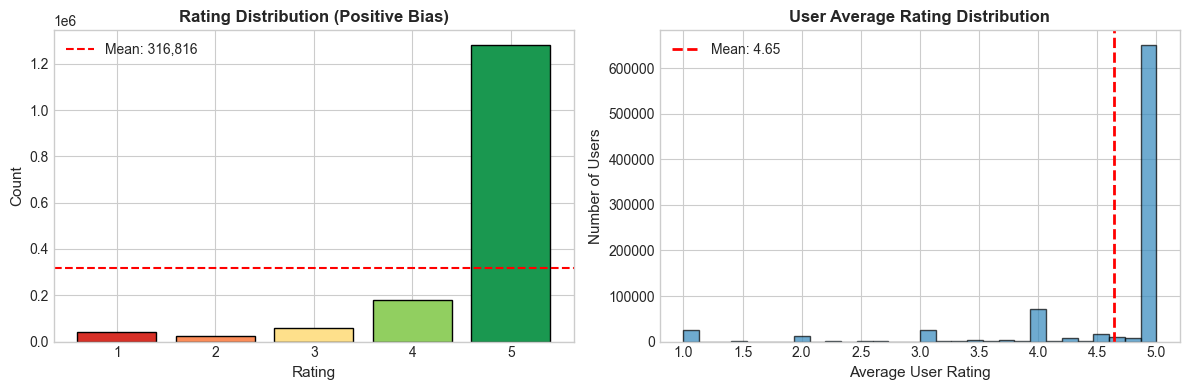

✓ Saved: rating_bias_analysis.png

📊 Interpretation:
   The dataset shows a POSITIVE RATING BIAS with mean=4.66.
   Higher ratings (4-5) are much more common than lower ratings (1-2).
   This is typical in product ratings where users tend to rate items
   they purchased and enjoyed.


In [48]:
# Rating bias analysis
print("\n" + "=" * 70)
print("2. RATING BIAS ANALYSIS")
print("=" * 70)

# Global statistics
global_mean = ratings['rating'].mean()
global_median = ratings['rating'].median()
global_std = ratings['rating'].std()

print(f"\nGlobal Rating Statistics:")
print(f"  Mean rating: {global_mean:.2f}")
print(f"  Median rating: {global_median:.2f}")
print(f"  Std deviation: {global_std:.2f}")

# Rating distribution
rating_dist = ratings['rating'].value_counts().sort_index()
print(f"\nRating Distribution:")
for rating, count in rating_dist.items():
    pct = count / n_ratings * 100
    print(f"  Rating {rating}: {count:,} ({pct:.2f}%)")

# Visualize rating bias
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rating distribution
colors_rating = ['#d73027', '#fc8d59', '#fee08b', '#91cf60', '#1a9850']
axes[0].bar(rating_dist.index, rating_dist.values, color=colors_rating, edgecolor='black')
axes[0].set_xlabel('Rating', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Rating Distribution (Positive Bias)', fontsize=12, fontweight='bold')
axes[0].axhline(y=rating_dist.mean(), color='red', linestyle='--', label=f'Mean: {rating_dist.mean():,.0f}')
axes[0].legend()

# User average rating distribution
axes[1].hist(r_u['ru'], bins=30, edgecolor='black', alpha=0.7, color='#3288bd')
axes[1].axvline(x=r_u['ru'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {r_u["ru"].mean():.2f}')
axes[1].set_xlabel('Average User Rating', fontsize=11)
axes[1].set_ylabel('Number of Users', fontsize=11)
axes[1].set_title('User Average Rating Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'rating_bias_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: rating_bias_analysis.png")

print("\n📊 Interpretation:")
print(f"   The dataset shows a POSITIVE RATING BIAS with mean={global_mean:.2f}.")
print(f"   Higher ratings (4-5) are much more common than lower ratings (1-2).")
print("   This is typical in product ratings where users tend to rate items")
print("   they purchased and enjoyed.")



3. LONG-TAIL PROBLEM ANALYSIS

Long-Tail Statistics:
  Top 10% of items account for: 61.67% of all ratings
  Top 20% of items account for: 71.89% of all ratings
  Bottom 50% of items account for: 14.42% of all ratings


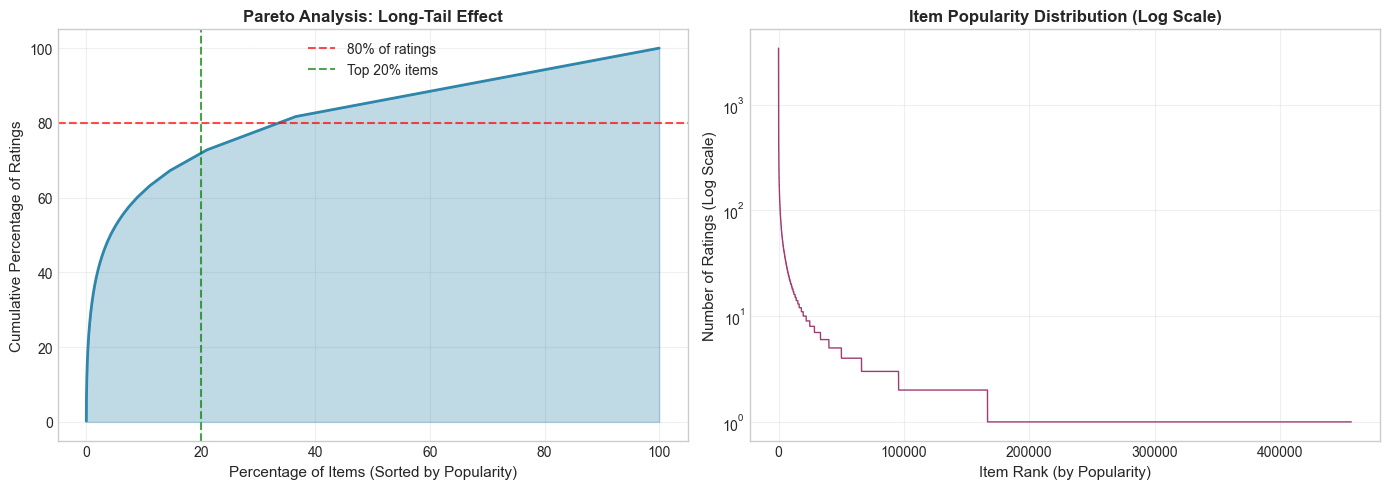

✓ Saved: long_tail_analysis.png

📊 Interpretation:
   The dataset exhibits a clear LONG-TAIL distribution.
   A small number of popular items receive the majority of ratings,
   while many items have very few ratings (the 'long tail').


In [49]:
# Long-tail analysis
print("\n" + "=" * 70)
print("3. LONG-TAIL PROBLEM ANALYSIS")
print("=" * 70)

# Sort items by popularity (number of ratings)
items_sorted = n_i.sort_values('ni', ascending=False).reset_index(drop=True)
items_sorted['cumulative_ratings'] = items_sorted['ni'].cumsum()
items_sorted['cumulative_pct'] = items_sorted['cumulative_ratings'] / n_ratings * 100
items_sorted['item_pct'] = (items_sorted.index + 1) / len(items_sorted) * 100

# Find key statistics
top_10_pct = items_sorted[items_sorted['item_pct'] <= 10]['cumulative_pct'].max()
top_20_pct = items_sorted[items_sorted['item_pct'] <= 20]['cumulative_pct'].max()
bottom_50_pct = 100 - items_sorted[items_sorted['item_pct'] <= 50]['cumulative_pct'].max()

print(f"\nLong-Tail Statistics:")
print(f"  Top 10% of items account for: {top_10_pct:.2f}% of all ratings")
print(f"  Top 20% of items account for: {top_20_pct:.2f}% of all ratings")
print(f"  Bottom 50% of items account for: {bottom_50_pct:.2f}% of all ratings")

# Visualize long-tail
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pareto chart
axes[0].plot(items_sorted['item_pct'], items_sorted['cumulative_pct'], 
             linewidth=2, color='#2E86AB')
axes[0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% of ratings')
axes[0].axvline(x=20, color='green', linestyle='--', alpha=0.7, label='Top 20% items')
axes[0].fill_between(items_sorted['item_pct'], items_sorted['cumulative_pct'], 
                     alpha=0.3, color='#2E86AB')
axes[0].set_xlabel('Percentage of Items (Sorted by Popularity)', fontsize=11)
axes[0].set_ylabel('Cumulative Percentage of Ratings', fontsize=11)
axes[0].set_title('Pareto Analysis: Long-Tail Effect', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log-scale popularity distribution
axes[1].semilogy(range(1, len(items_sorted) + 1), items_sorted['ni'], 
                 linewidth=1, color='#A23B72')
axes[1].set_xlabel('Item Rank (by Popularity)', fontsize=11)
axes[1].set_ylabel('Number of Ratings (Log Scale)', fontsize=11)
axes[1].set_title('Item Popularity Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'long_tail_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: long_tail_analysis.png")

print("\n📊 Interpretation:")
print(f"   The dataset exhibits a clear LONG-TAIL distribution.")
print(f"   A small number of popular items receive the majority of ratings,")
print(f"   while many items have very few ratings (the 'long tail').")
